# Plot heatmap of animal location

- This script plots heatmaps and saves them it in pdf figures.


| ![](../images/heatmap.jpg) | 
|:--:| 
|HeatMap of animal location|


Code launched.
Start : 0
Entry (in frame) : 0
End : 2d
Entry (in frame) : 5184000
D:/live mouse tracker data/Experiment 8/Experiment 8.sqlite
 8/Experiment 8
Loading animals.
Fields available in lmtanalysis:  ['ID', 'RFID', 'GENOTYPE', 'NAME']
SQL Query: SELECT ID,RFID,NAME,GENOTYPE FROM ANIMAL ORDER BY GENOTYPE
Animal Id:2 Name:B RFID:000022986552 Genotype:KO User1:None
Animal Id:3 Name:C RFID:000022986494 Genotype:KO User1:None
Animal Id:1 Name:A RFID:000022986394 Genotype:WT User1:None
Animal Id:4 Name:D RFID:000022986530 Genotype:WT User1:None
Animal Id:2 Name:B RFID:000022986552 Genotype:KO User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHERE ANIMALID=2 AND FRAMENUMBER>=0 AND FRAMENUMBER<=5184000
Animal Id:2 Name:B RFID:000022986552 Genotype:KO User1:None   2004545  detections loaded in 201.21610927581787 seconds.
Animal Id:3 Name:C RFID:000022986494 Genotype:KO User1:None : Loading detection.
SELECT FRAMENUMBER, MASS_X, MASS_Y FROM DETECTION WHE

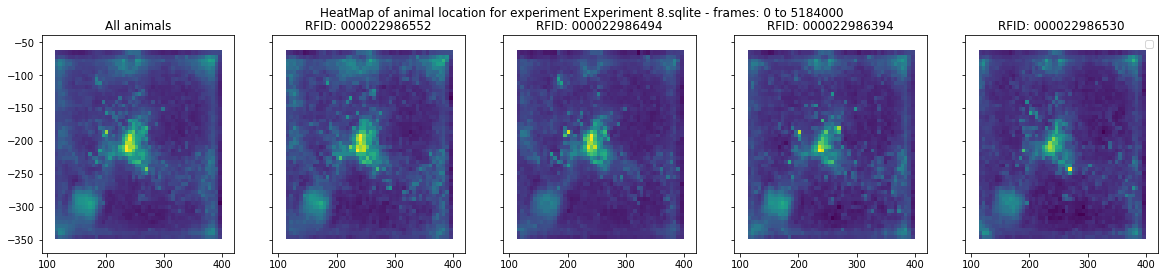

In [1]:
import sys
sys.path.insert(1, "../")

import sqlite3
from lmtanalysis.Animal import *
import matplotlib.pyplot as plt
from lmtanalysis.Event import *
from lmtanalysis.Measure import *

import lmtanalysis
from tkinter.filedialog import askopenfilename
from tabulate import tabulate
from collections import Counter
import collections
import xlsxwriter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors

import os
from lmtanalysis.FileUtil import getFilesToProcess
from lmtanalysis.Util import convert_to_d_h_m_s, getFrameInput


def frameToTimeTicker(x, pos):
   
    vals= convert_to_d_h_m_s( x )
    return "D{0} - {1:02d}:{2:02d}".format( int(vals[0])+1, int(vals[1]), int(vals[2]) )
    

print("Code launched.")

#Choose the files to process
files = getFilesToProcess()

tmin = getFrameInput("Start")
tmax = getFrameInput("End")

for file in files:

    print(file)
    expName = file[-22:-7]
    print( expName )

    connection = sqlite3.connect( file )

    pool = AnimalPool( )
    pool.loadAnimals( connection )
    pool.loadDetection( start = tmin, end = tmax, lightLoad=True)

    pool.filterDetectionByArea( 0, 0, 50, 50 );

    nbCols = len( pool.getAnimalList() )+1
    fig, axes = plt.subplots( nrows = 1 , ncols = nbCols , figsize=( nbCols*4, 1*4 ) , sharex='all', sharey='all'  )
    gamma = 0.3 # enhance low values. See https://matplotlib.org/3.1.1/gallery/scales/power_norm.html
    
    title= "HeatMap of animal location for experiment " + os.path.basename(file) + " - frames: " + str(tmin)+ " to " + str(tmax)
    
    #draw all animals
    axis = axes[0]
    legendList=[]
    dataX = []
    dataY = []
    for animal in pool.getAnimalList():

        print ("Compute trajectory of animal " + animal.name )
        for detection in animal.detectionDictionnary.values():
            dataX.append( detection.massX )
            dataY.append( -detection.massY ) #reversed y to get the same orientation as in the video
    
    axis.hist2d( dataX, dataY, bins=50, norm=mcolors.PowerNorm(gamma))    
    axis.set_title( "All animals" )
    axis.set_xlim(90, 420)
    axis.set_ylim(-370, -40)
        

    #draw separated animals
    for animal in pool.getAnimalList():
        
        dataX = []
        dataY = []
        axis = axes[pool.getAnimalList().index(animal)+1]

        print ("Compute trajectory of animal " + animal.name )
        
        for detection in animal.detectionDictionnary.values():
            dataX.append( detection.massX )
            dataY.append( -detection.massY ) #reversed y to get the same orientation as in the video
    
        print ("Draw trajectory of animal " + animal.name )

        axis.hist2d( dataX, dataY, bins=50, norm=mcolors.PowerNorm(gamma))    
        axis.set_title( "RFID: "+animal.RFID )
        axis.set_xlim(90, 420)
        axis.set_ylim(-370, -40)


    axis.legend( handles = legendList , loc=1 )

    fig.suptitle( title )
    
    print ("Saving figure...")
    figureFileName = "plot heatmap location_{}_{}.pdf".format( str(tmin), str(tmax) )
    figureFileName = file+"."+figureFileName
    print( "Saving figure to ", figureFileName )
    fig.savefig( figureFileName ,dpi=100)
    plt.show()
    plt.close( fig )
    